# Load the Dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-data/download.jpeg
/kaggle/input/test-data/download (1).jpeg
/kaggle/input/tacotrashdataset/best-checkpoint-003epoch.bin
/kaggle/input/tacotrashdataset/meta_df.csv
/kaggle/input/tacotrashdataset/kle_log.txt
/kaggle/input/tacotrashdataset/data/annotations.json
/kaggle/input/tacotrashdataset/data/batch_4/000050.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000081.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000040.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000021.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000015.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000096.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000029.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000076.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000056.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000077.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000084.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000018.JPG
/kaggle/input/tacotrashdataset/data/batch_4/000031.JPG
/kaggl

# Installing the Libraries

# Converting TACO Dataset to YOLO Format and Training YOLOv8

## Overview

This notebook converts the TACO (Trash Annotations in Context) dataset to the YOLO format and trains a YOLOv8 model for waste detection. The TACO dataset contains annotated images of litter in diverse real-world environments, making it useful for object detection tasks related to waste classification.

## Steps Involved

### 1. Convert TACO Annotations to YOLO Format

The provided function convert_taco_to_yolo reads the JSON annotations from the TACO dataset and converts them into the YOLO format. This includes:

- Extracting image and annotation details.

- Splitting the dataset into training (80%) and validation (20%) subsets.

- Saving images and their corresponding label files in YOLO format.

### 2. Generate data.yaml

A data.yaml file is created to define the dataset's path, number of classes, and class names. This file is essential for training YOLO models.

### 3. Train YOLOv8

We use the Ultralytics YOLOv8 model (yolov8n.pt) to train on the converted dataset. The model is trained for 50 epochs with an image size of 640x640 pixels.

## Implementation

### Data Conversion

The function convert_taco_to_yolo performs the following:

- Loads the annotations JSON file.

- Creates directories for training and validation images and labels.

- Copies images to respective directories.

- Converts bounding box coordinates from COCO format (x, y, width, height) to YOLO format (x_center, y_center, width, height as fractions of image dimensions).

- Saves the annotations in .txt format with class IDs.

### Training

- The YOLO class from ultralytics is used to train the YOLOv8 model.

- The training runs for 50 epochs using the dataset defined in data.yaml.

- Results, including loss metrics and mAP (mean Average Precision), can be analyzed for performance evaluation.

## Expected Outcome

After training, the YOLOv8 model will be capable of detecting waste in images. The trained weights can be used for inference on new images or deployed on edge devices for real-time waste detection.

## Potential Applications

- Waste management and recycling automation

- Environmental monitoring

- Smart city initiatives for cleaner public spaces

This notebook provides an efficient pipeline for converting the TACO dataset into YOLO format and training a robust object detection model.



In [2]:
!pip install -U ultralytics
import ultralytics
ultralytics.checks()

import json
import os
from sklearn.model_selection import train_test_split
import shutil

Ultralytics 8.3.223 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6515.8/8062.4 GB disk)


In [3]:
import json
import os
from sklearn.model_selection import train_test_split
import shutil
from ultralytics import YOLO

def convert_taco_to_yolo(json_path, image_root_dir, output_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)

    image_ids = [img['id'] for img in images]
    train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

    image_id_to_filename = {img['id']: img['file_name'] for img in images}
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    for img in images:
        img_id = img['id']
        filename = img['file_name']
        img_width = img['width']
        img_height = img['height']

        if img_id in train_ids:
            image_dir = os.path.join(output_dir, 'images/train')
            label_dir = os.path.join(output_dir, 'labels/train')
        else:
            image_dir = os.path.join(output_dir, 'images/val')
            label_dir = os.path.join(output_dir, 'labels/val')

        full_image_path = os.path.join(image_root_dir, filename)

        if os.path.exists(full_image_path):
            shutil.copy(full_image_path, os.path.join(image_dir, filename.split('/')[-1]))
        else:
            print(f"Warning: Image {full_image_path} not found.")
            continue

        label_file = os.path.join(label_dir, filename.split('/')[-1].replace('.jpg', '.txt').replace('.JPG', '.txt'))

        with open(label_file, 'w') as lf:
            for ann in annotations:
                if ann['image_id'] == img_id:
                    category_id = ann['category_id']
                    bbox = ann['bbox']
                    x_center = (bbox[0] + bbox[2] / 2) / img_width
                    y_center = (bbox[1] + bbox[3] / 2) / img_height
                    width = bbox[2] / img_width
                    height = bbox[3] / img_height
                    lf.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

output_yolo_dir = '/kaggle/working/taco_yolo'
image_root_dir = '/kaggle/input/tacotrashdataset/data'
convert_taco_to_yolo('/kaggle/input/tacotrashdataset/data/annotations.json', image_root_dir, output_yolo_dir)

# Create data.yaml
with open('/kaggle/working/taco_yolo/data.yaml', 'w') as f:
    f.write(f"train: {os.path.abspath('/kaggle/working/taco_yolo/images/train')}\n")
    f.write(f"val: {os.path.abspath('/kaggle/working/taco_yolo/images/val')}\n")
    f.write("nc: 60\n") #number of classes in the dataset.
    categories = json.load(open('/kaggle/input/tacotrashdataset/data/annotations.json', 'r'))['categories']
    f.write("names: " + str([cat['name'] for cat in categories]) + "\n")

# Train YOLOv8
model = YOLO('yolov8n.pt')
results = model.train(data='/kaggle/working/taco_yolo/data.yaml', epochs=50, imgsz=640,project='/kaggle/working/runs', name='taco_train')

Ultralytics 8.3.223 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/taco_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=taco_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        182        492      0.404     0.0771      0.063     0.0547
        Aluminium foil          1          2          0          0          0          0
  Other plastic bottle          9          9          0          0     0.0139     0.0139
  Clear plastic bottle         31         37       0.25      0.108      0.128      0.103
          Glass bottle          5          9          0          0    0.00637    0.00582
    Plastic bottle cap         28         30      0.217     0.0333     0.0567     0.0258
      Metal bottle cap          7         13      0.265     0.0769     0.0423     0.0331
              Food Can          1          2          1          0     0.0508     0.0407
               Aerosol          4          4          1          0          0          0
             Drink can         21         23      0.146       0.13     0.0918     0.0804
           Toilet tube          1          1          0          0          0          0
          Other carto

# Inference on Validation Images

## Run Inference: Use the trained model to make predictions on the validation images.

In [4]:
from ultralytics import YOLO
import cv2
import os

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Directory containing validation images
val_images_dir = '/kaggle/working/taco_yolo/images/val'

# Directory to save the results.
results_dir = '/kaggle/working/inference_results'
os.makedirs(results_dir, exist_ok=True)

# Iterate over validation images
for filename in os.listdir(val_images_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(val_images_dir, filename)
        image = cv2.imread(image_path)

        # Perform inference
        results = model(image)

        # Visualize results
        annotated_image = results[0].plot()

        # Save annotated image
        output_path = os.path.join(results_dir, f'annotated_{filename}')
        cv2.imwrite(output_path, annotated_image)

print(f"Inference results saved to {results_dir}")


0: 640x480 (no detections), 35.3ms
Speed: 2.8ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 (no detections), 6.9ms
Speed: 3.5ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 (no detections), 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 (no detections), 57.0ms
Speed: 3.2ms preprocess, 57.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x320 1 Unlabeled litter, 34.7ms
Speed: 2.1ms preprocess, 34.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x480 (no detections), 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 (no detections), 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 (no detections), 6.7ms
Speed: 2.6ms preprocess, 6.7ms inferenc

Ultralytics 8.3.223 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,017,348 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4885.4±895.5 MB/s, size: 1793.2 KB)
val: Scanning /kaggle/working/taco_yolo/labels/val.cache... 182 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 182/182 348.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 1.8it/s 6.7s0.3s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        182        492      0.406     0.0734     0.0635     0.0547
        Aluminium foil          1          2          0          0          0          0
  Other plastic bottle          9          9          0          0     0.0113     0.0113
  Clear plastic bottle         31         37      0.239     0.0768      0.127      0.104
          Glass bottle          5          9          0          0    0.00588    0.00472
    Plastic bottle cap         28         30      0.212     0.0333     0.0582     0.0251
      Metal bottle cap          7         13      0.276     0.0769     0.0422      0.037
              Food Can          1          2          1          0     0.0464     0.0371
               Aerosol          4          4          1          0          0          0
             Drink can         21         23      0.179       0.13     0.0874     0.0727
           Toilet tube          1          1          0          0          0          0
          Other carto

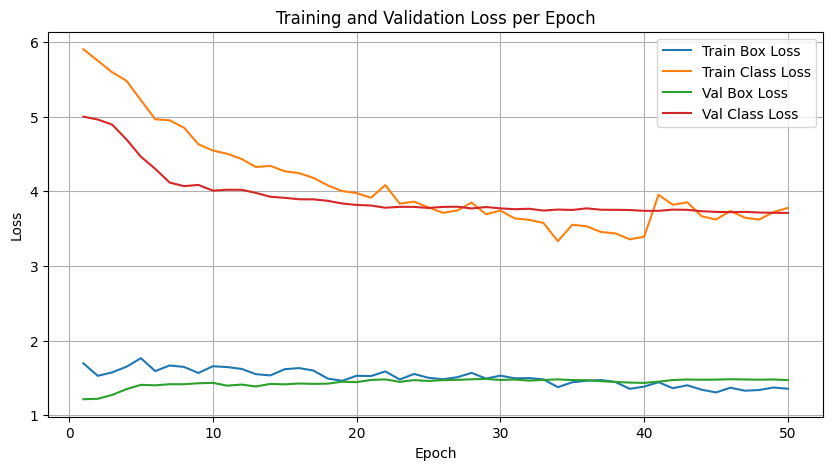

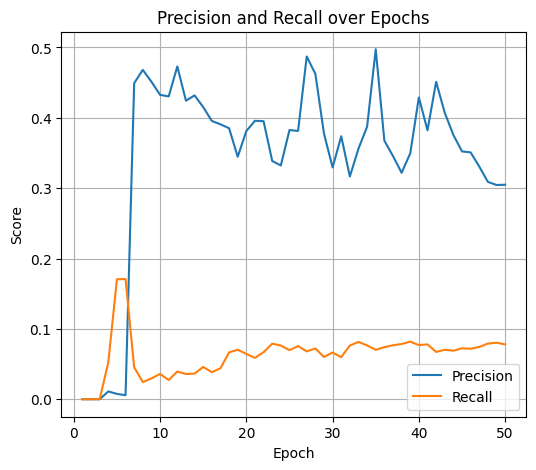

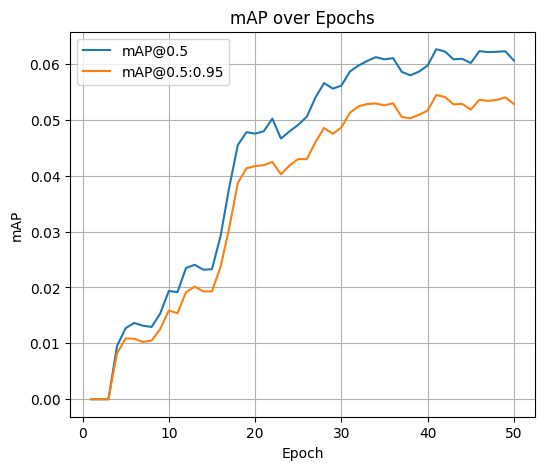

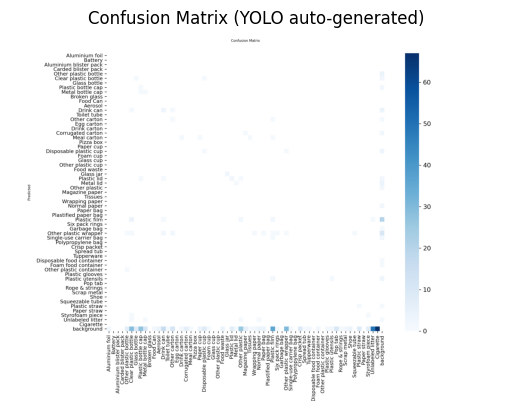

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from ultralytics import YOLO

# Đường dẫn model đã train
model_path = '/kaggle/working/runs/taco_train/weights/best.pt'
model = YOLO(model_path)

# Đánh giá model
metrics = model.val(data='/kaggle/working/taco_yolo/data.yaml')

# In các chỉ số chính
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")

# F1-score (tự tính)
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.4f}")

# Đọc file kết quả huấn luyện
results_csv = '/kaggle/working/runs/taco_train/results.csv'
df = pd.read_csv(results_csv)

# Biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/loss_curve.png")
plt.show()

# Biểu đồ Precision & Recall
plt.figure(figsize=(6, 5))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision and Recall over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/precision_recall_curve.png")
plt.show()

# Biểu đồ mAP
plt.figure(figsize=(6, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/map_curve.png")
plt.show()

# Confusion matrix (YOLO tự sinh ra)
# Nếu đã có file, chỉ cần hiển thị lại
conf_path = '/kaggle/working/runs/taco_train/confusion_matrix.png'
if os.path.exists(conf_path):
    from PIL import Image
    img = Image.open(conf_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix (YOLO auto-generated)")
    plt.show()
else:
    model.plot_confusion_matrix(save_dir='/kaggle/working/runs/taco_train/')
    print("Confusion matrix saved in /kaggle/working/runs/taco_train/")


In [6]:
from ultralytics import YOLO
import cv2
import os

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Path to your test image (replace with your actual path)
image_path = '/kaggle/input/test-data/download.jpeg'  # Or '/kaggle/working/your_image.jpg'

# Load the image
image = cv2.imread(image_path)

# Perform inference
results = model(image)

# Visualize results
annotated_image = results[0].plot()

# Save the annotated image
output_path = '/kaggle/working/annotated_your_image.jpeg' # or annotated_your_image.jpg
cv2.imwrite(output_path, annotated_image)

print(f"Inference results saved to {output_path}")


0: 480x640 1 Plastic film, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Inference results saved to /kaggle/working/annotated_your_image.jpeg


In [7]:
from ultralytics import YOLO
import cv2
import os

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Path to your test image (replace with your actual path)
image_path = '/kaggle/input/test-data/download (1).jpeg'  # Or '/kaggle/working/your_image.jpg'

# Load the image
image = cv2.imread(image_path)

# Perform inference
results = model(image)

# Visualize results
annotated_image = results[0].plot()

# Save the annotated image
output_path = '/kaggle/working/annotated_your_image1.jpeg' # or annotated_your_image.jpg
cv2.imwrite(output_path, annotated_image)

print(f"Inference results saved to {output_path}")


0: 480x640 1 Drink can, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Inference results saved to /kaggle/working/annotated_your_image1.jpeg


In [8]:
!ls /kaggle/working/runs/taco_train/weights

best.pt  last.pt
